# 🧪 Ingredient Clustering Explorer

This notebook clusters cosmetic product formulations based on their INCI ingredient lists using unsupervised learning techniques.

## 🧭 Workflow
- Load and clean formulation data
- Vectorize using TF-IDF
- Cluster with KMeans
- Visualize clusters with UMAP
- Show top ingredients per cluster

In [6]:
!/Library/Frameworks/Python.framework/Versions/3.13/bin/python3.13 -m pip install umap matplotlib umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 5.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [umap-learn]4 [numba]


In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Config
sns.set(style="whitegrid", palette="muted")


## 📥 Load and Process Formulation Data

In [8]:
# Load formulation dataset
df = pd.read_csv("formulations_cleaned.csv")

# Group by product_name and concatenate ingredients
df_grouped = df.groupby("product_name")["inci"].apply(lambda x: ", ".join(sorted(set(x.dropna())))).reset_index()
df_grouped.columns = ["product_name", "ingredient_list"]
df_grouped["ingredient_list"] = df_grouped["ingredient_list"].str.lower().str.strip()

df_grouped.head()

,product_name,ingredient_list
0,(Sephora) Cosmo Lip Scrub- Cherry,"flavor, ricinus communis (castor) seed oil (an..."
1,(Sephora) Cosmo Lip Scrub- Coconut,"cocos nucifera (coconut) oil, flavor, ricinus ..."
2,(Sephora) Cosmo Lip Scrub- Dragon Fruit,"flavor, ricinus communis (castor) seed oil (an..."
3,(Sephora) Cosmo Lip Scrub- Lychee,butylene glycol (and) litchi chinensis pericar...
4,(Sephora) Cosmo Lip Scrub- Rose,"flavor, ricinus communis (castor) seed oil (an..."


## 🧪 TF-IDF Vectorization

In [9]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(", "))
X = vectorizer.fit_transform(df_grouped["ingredient_list"])
X.shape

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1216, 972)

## 📦 KMeans Clustering

In [12]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
df_grouped["cluster"] = kmeans.fit_predict(X)

df_grouped["cluster"].value_counts().sort_index()

cluster
0     19
1     94
2    109
3    144
4     80
5    447
6     92
7     63
8     68
9    100
Name: count, dtype: int64

Silhouette scores for different k:
  k=3: 0.038
  k=4: 0.053
  k=5: 0.069
  k=6: 0.075
  k=7: 0.082
  k=8: 0.077
  k=9: 0.089
  k=10: 0.098


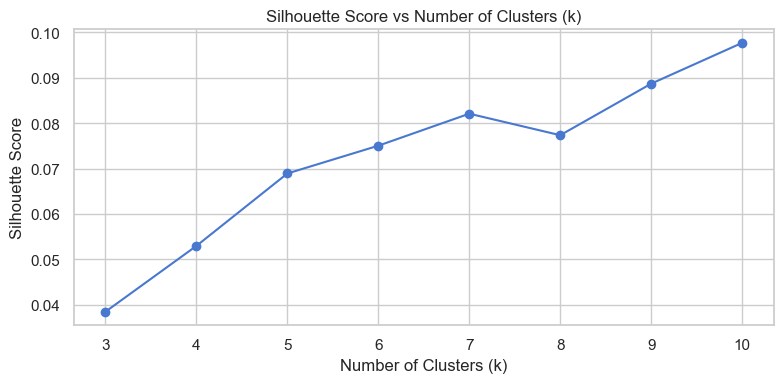

In [11]:
# Evaluate optimal number of clusters using silhouette scores
from sklearn.metrics import silhouette_score

scores = {}
print("Silhouette scores for different k:")
for k in range(3, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores[k] = score
    print(f"  k={k}: {score:.3f}")

# Optional: visualize scores
plt.figure(figsize=(8, 4))
plt.plot(list(scores.keys()), list(scores.values()), marker="o")
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(range(3, 11))
plt.grid(True)
plt.tight_layout()
plt.show()


## 📉 UMAP Dimensionality Reduction

In [13]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X.toarray())

df_grouped["x"] = embedding[:, 0]
df_grouped["y"] = embedding[:, 1]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## 📊 Visualize Clusters in 2D

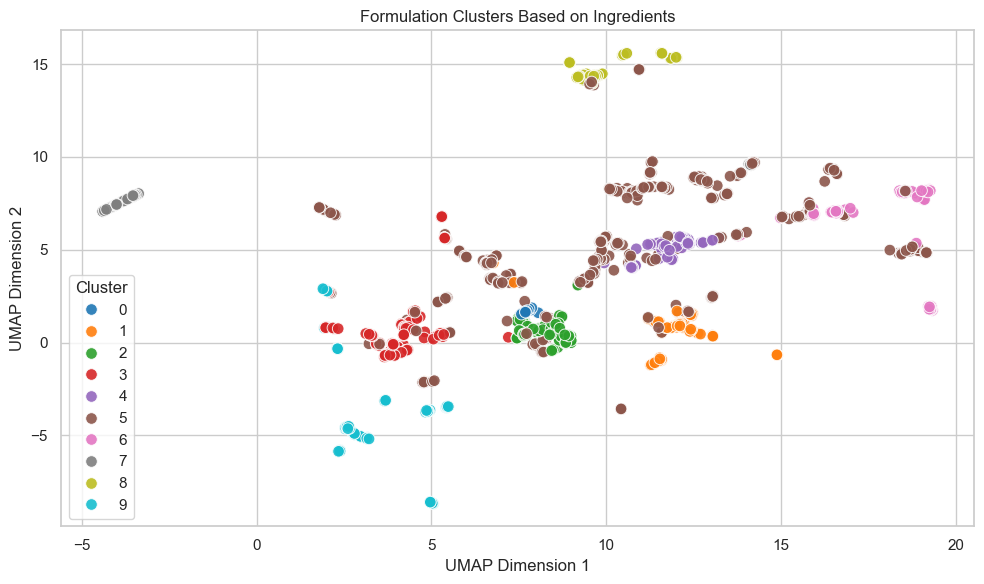

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_grouped, x="x", y="y", hue="cluster", palette="tab10", s=70, alpha=0.9)
plt.title("Formulation Clusters Based on Ingredients")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


## 🔍 Top Ingredients per Cluster

In [15]:
# Extract top ingredients per cluster
ingredient_lists = df_grouped.groupby("cluster")["ingredient_list"].apply(lambda x: ", ".join(x)).reset_index()

def top_ingredients(text, top_n=10):
    all_ingredients = text.split(", ")
    return Counter(all_ingredients).most_common(top_n)

for _, row in ingredient_lists.iterrows():
    print(f"\nCluster {row['cluster']} – Top Ingredients:")
    for ingredient, count in top_ingredients(row["ingredient_list"]):
        print(f"  {ingredient}: {count}x")



Cluster 0 – Top Ingredients:
  glycerin: 20x
  fragrance: 19x
  sodium laureth sulfate: 18x
  deionized water: 17x
  sodium cocoyl isethionate: 16x
  niacinamide: 10x
  ci 42090: 8x
  hydrolyzed collagen: 6x
  tocopheryl acetate: 6x
  tranexamic acid: 5x

Cluster 1 – Top Ingredients:
  deionized water: 90x
  fragrance: 72x
  disodium edta: 66x
  ethanol: 62x
  triethanolamine: 53x
  propylene glycol: 42x
  methylchloroisothiazolinone / methylisothiazolinone: 40x
  carbomer: 39x
  glycerin: 38x
  acrylates/c10-30 alkyl acrylate crosspolymer: 34x

Cluster 2 – Top Ingredients:
  deionized water: 107x
  sodium palmate: 105x
  sodium palm kernelate: 105x
  glycerin: 100x
  fragrance: 93x
  sodium lauryl sulfate: 81x
  niacinamide: 69x
  ci 19140: 49x
  ci 15985: 40x
  prunus amygdalus dulcis (sweet almond) oil: 39x

Cluster 3 – Top Ingredients:
  sodium chloride: 143x
  deionized water: 140x
  fragrance: 135x
  sodium laureth sulfate: 133x
  cocamidopropyl betaine: 127x
  citric acid: 122x

## 💾 Export Clustered Data (Optional)

In [16]:
df_grouped.to_csv("clustered_formulations.csv", index=False)
print("Clustered data saved to clustered_formulations.csv")


Clustered data saved to clustered_formulations.csv
